<h1>GIWAXS analysis using pyFAI<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Manual-for-this-notebook" data-toc-modified-id="Manual-for-this-notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Manual for this notebook</a></span></li><li><span><a href="#Batch-functions" data-toc-modified-id="Batch-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Batch functions</a></span></li><li><span><a href="#Beam-parameters" data-toc-modified-id="Beam-parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Beam parameters</a></span></li><li><span><a href="#Load-images" data-toc-modified-id="Load-images-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load images</a></span></li><li><span><a href="#Conversion-to-q-space" data-toc-modified-id="Conversion-to-q-space-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conversion to q-space</a></span></li><li><span><a href="#Powder-plot" data-toc-modified-id="Powder-plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Powder plot</a></span></li><li><span><a href="#2D-integration" data-toc-modified-id="2D-integration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>2D integration</a></span></li><li><span><a href="#Radial-integration-&amp;-Pole-figure" data-toc-modified-id="Radial-integration-&amp;-Pole-figure-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Radial integration &amp; Pole figure</a></span></li><li><span><a href="#In-plane-&amp;-out-of-plane-integration" data-toc-modified-id="In-plane-&amp;-out-of-plane-integration-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>In-plane &amp; out-of-plane integration</a></span></li></ul></div>

# Manual for this notebook

This notebook is a tutorial notebook to introduce our users to the library pyFAI for GIWAXS analysis.  

See the online manual for explanation of each step: https://arnaudhemmerle.github.io/data-analysis-on-sirius/chapters/giwaxs/pyfai/about.html

# Batch functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import matplotlib.patches as patches
import pyFAI as pyFAI
from PIL import Image
import fabio
import os
import glob

import pyFAI.detectors
from pyFAI.method_registry import IntegrationMethod
from pyFAI.units import get_unit_fiber
from pyFAI.multi_geometry import MultiGeometry

print("Using pyFAI version: ", pyFAI.version)



Using pyFAI version:  2025.1.0


# Beam parameters

In [20]:
# Beam parameters
wavelength = 1.24 # in Angstrom
sample_detector_distance = 350 # in mm
PONIx = 563.5 # in pixel
PONIy = 1015 # in pixel
delta = -8.7 # in deg
incident_angle = 0.12 # in deg

# Out-of-plane angle for each image
gamma_A = -0.75 # in deg
gamma_B = -1.4 # in deg

# Folder with raw data
folder_raw_data = "raw_data/"

# List of pairs of scan numbers corresponding to [gamma_A, gamma_B]
scan_list = [(5151, 5152), (5153,5154)]

# Maximum q in the images
max_qip = 20 #in-plane, in 1/nm
max_qoop = 20 #out-of-plane, in 1/nm

# Number of data points in the powder plots
npt_powder_plot = 600


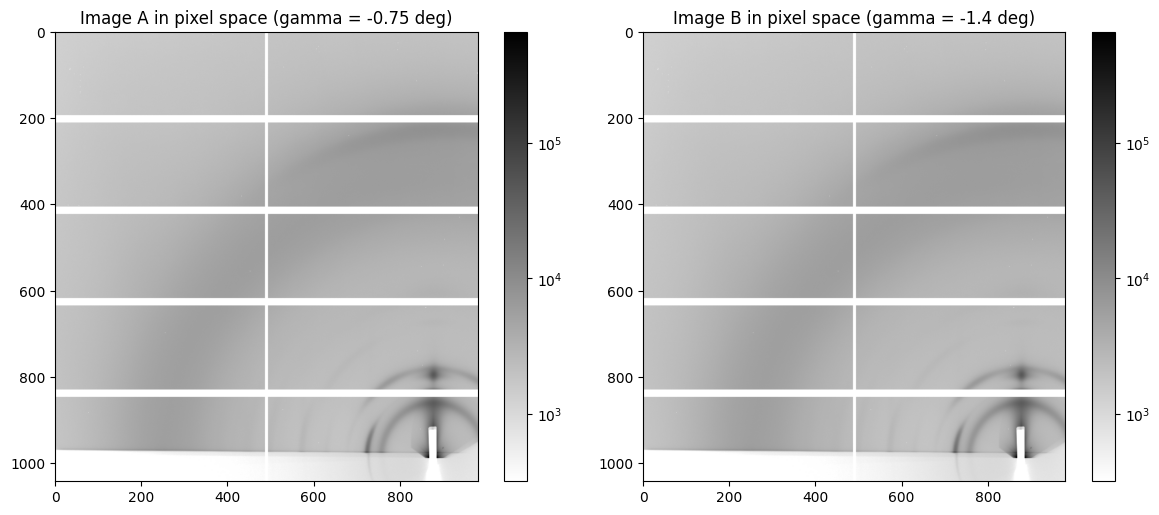

Folder created for saving processed data:
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/


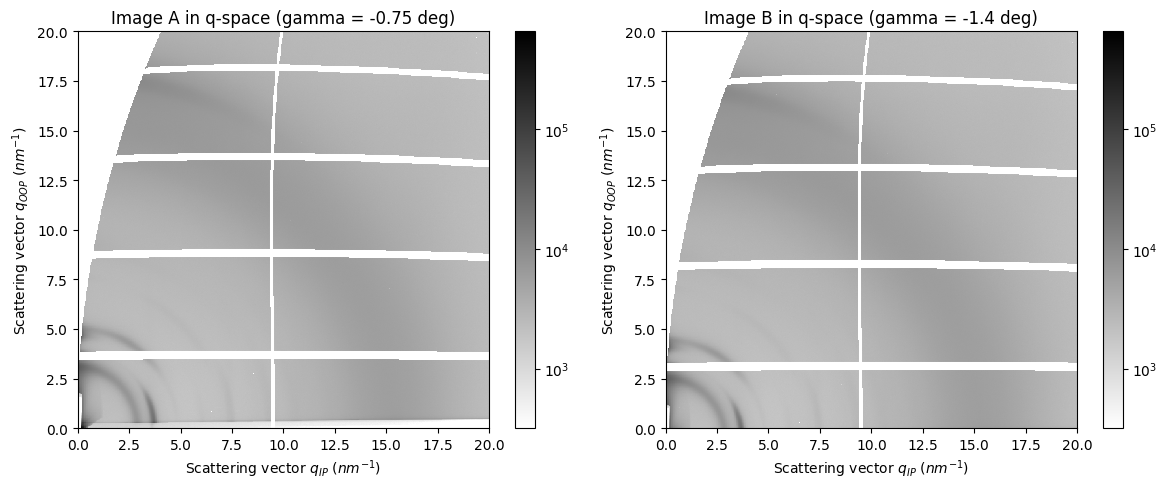

Images saved as PNG & TIFF:
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/images_qspace.png
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/I_A_qspace.tiff
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/I_B_qspace.tiff
Data saved as .dat files with headers:
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/qip_A.dat
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/qoop_A.dat
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/qip_B.dat
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/qoop_B.dat


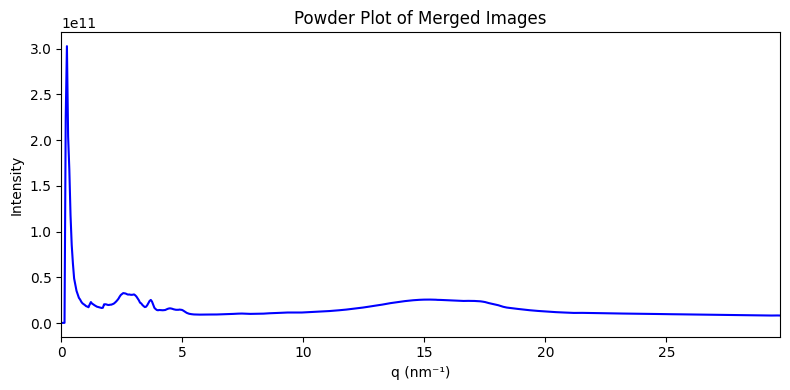

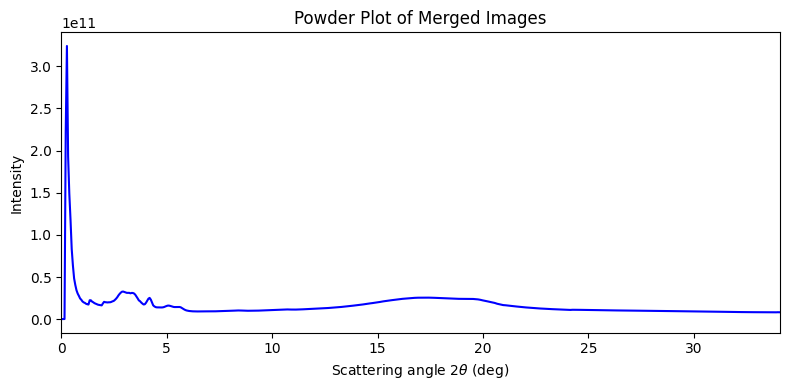

Images saved as PNG:
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/powder_plot_q.png
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/powder_plot_tth.png
Data saved as .dat files with headers:
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/powder_q.dat
processed_data/SIRIUS_2024_11_22_5151_pilatus_sum/powder_tth.dat


In [21]:
# Load images

i = 0
scan_ind_A = scan_list[i][0]
scan_ind_B = scan_list[i][0]

path_A = glob.glob(os.path.join(folder_raw_data, f'*{scan_ind_A}_pilatus_sum.tiff'))[0]
path_B = glob.glob(os.path.join(folder_raw_data, f'*{scan_ind_B}_pilatus_sum.tiff'))[0]

# LOAD IMAGES
img_A = fabio.open(path_A).data
img_B = fabio.open(path_B).data

# You may want to adjust the contrast of the image with vmin and vmax
vmin = np.nanpercentile(img_A,10)
vmax = np.nanmax(img_A)

# Create folder to store the results
filename = os.path.splitext(os.path.basename(path_A))[0]
folder_path = f"processed_data/{filename}"
os.makedirs(folder_path, exist_ok=True)

# Play with the values of vmin and vmax to adjust contrast
colornorm = SymLogNorm(1, base=10,
                       vmin=vmin,
                       vmax=vmax)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first image
axes[0].imshow(img_A, origin='upper', cmap="gray_r", norm=colornorm)
axes[0].set_title(f'Image A in pixel space (gamma = {gamma_A} deg)')
fig.colorbar(plt.cm.ScalarMappable(norm=colornorm, cmap="gray_r"), ax=axes[0])

# Plot the second image
axes[1].imshow(img_B, origin='upper', cmap="gray_r", norm=colornorm)
axes[1].set_title(f'Image B in pixel space (gamma = {gamma_B} deg)')
fig.colorbar(plt.cm.ScalarMappable(norm=colornorm, cmap="gray_r"), ax=axes[1])

# Show the figure
plt.tight_layout()
plt.show()

print(f"Folder created for saving processed data:\n{folder_path}/")

# CONVERSION TO Q-SPACE

# Set-up the geometry for each image
ai_A = pyFAI.load({"detector": pyFAI.detectors.Pilatus1M(), "wavelength": wavelength*1e-10})
ai_A.setFit2D(sample_detector_distance, PONIx, PONIy)
ai_A.rot1 = delta*np.pi/180.
ai_A.rot2 = gamma_A*np.pi/180.

ai_B = pyFAI.load({"detector": pyFAI.detectors.Pilatus1M(), "wavelength": wavelength*1e-10})
ai_B.setFit2D(sample_detector_distance, PONIx, PONIy)
ai_B.rot1 = delta*np.pi/180.
ai_B.rot2 = gamma_B*np.pi/180.

# Integration method
m = IntegrationMethod.select_method(dim=2, split="no", algo="CSR")[0]

# Define the units
unit_qip = get_unit_fiber(name="qip_nm^-1", incident_angle=incident_angle*np.pi/180., tilt_angle=0., sample_orientation=3)
unit_qoop = get_unit_fiber(name="qoop_nm^-1", incident_angle=incident_angle*np.pi/180., tilt_angle=0., sample_orientation=3)
unit_qx = get_unit_fiber(name="qxgi_nm^-1", incident_angle=incident_angle*np.pi/180., tilt_angle=0., sample_orientation=3)

I_A, qip_A, qoop_A  = ai_A.integrate2d(img_A, npt_rad = int(1043*0.8), npt_azim = int(981*0.8), method=m, unit=(unit_qip, unit_qoop))
I_B, qip_B, qoop_B = ai_B.integrate2d(img_B, npt_rad = int(1043*0.8), npt_azim = int(981*0.8), method=m, unit=(unit_qip, unit_qoop))



# Define color normalization
colornorm = SymLogNorm(1, base=10, vmin=vmin, vmax=vmax)

# Create figure and axes for side-by-side images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Image A in q-space
cbar_A = axes[0].pcolormesh(qip_A, qoop_A, I_A, cmap="gray_r", norm=colornorm)
axes[0].set_xlim(0, max_qip)
axes[0].set_ylim(0, max_qoop)
axes[0].set_xlabel(unit_qip.label)
axes[0].set_ylabel(unit_qoop.label)
axes[0].set_title(f'Image A in q-space (gamma = {gamma_A} deg)')
fig.colorbar(cbar_A, ax=axes[0])

# Plot Image B in q-space
cbar_B = axes[1].pcolormesh(qip_B, qoop_B, I_B, cmap="gray_r", norm=colornorm)
axes[1].set_xlim(0, max_qip)
axes[1].set_ylim(0, max_qoop)
axes[1].set_xlabel(unit_qip.label)
axes[1].set_ylabel(unit_qoop.label)
axes[1].set_title(f'Image B in q-space (gamma = {gamma_B} deg)')
fig.colorbar(cbar_B, ax=axes[1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f"{folder_path}/images_qspace.png", dpi=300)  # Save both images together
plt.show()

# Save I_A and I_B as TIFF images using PIL
Image.fromarray(I_A.astype(np.float32)).save(f"{folder_path}/I_A_qspace.tiff")
Image.fromarray(I_B.astype(np.float32)).save(f"{folder_path}/I_B_qspace.tiff")

# Save qip and qoop data with headers
header_qip = f"# {unit_qip.label} values"
header_qoop = f"# {unit_qoop.label} values"

np.savetxt(f"{folder_path}/qip_A.dat", qip_A, header=header_qip, comments="")
np.savetxt(f"{folder_path}/qoop_A.dat", qoop_A, header=header_qoop, comments="")

np.savetxt(f"{folder_path}/qip_B.dat", qip_B, header=header_qip, comments="")
np.savetxt(f"{folder_path}/qoop_B.dat", qoop_B, header=header_qoop, comments="")

print("Images saved as PNG & TIFF:")
print(f"{folder_path}/images_qspace.png")
print(f"{folder_path}/I_A_qspace.tiff")
print(f"{folder_path}/I_B_qspace.tiff")
print("Data saved as .dat files with headers:")
print(f"{folder_path}/qip_A.dat")
print(f"{folder_path}/qoop_A.dat")
print(f"{folder_path}/qip_B.dat")
print(f"{folder_path}/qoop_B.dat")

# POWDER PLOT

######## In q space #############

# Powder plot after merging
mg = MultiGeometry([ai_A, ai_B], unit="q_nm^-1", azimuth_range=(-180, -90))
q_AB, Iq_AB = mg.integrate1d([img_A, img_B], npt = npt_powder_plot, method=("no", "histogram", "cython"))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot I_A and I_B on the primary y-axis (left)
plt.plot(q_AB, Iq_AB, 'b-')
plt.xlabel("q (nm⁻¹)")
plt.ylabel("Intensity")
plt.xlim(0, np.max(q_AB))

# Adjust layout and save the figure
plt.title("Powder Plot of Merged Images")
plt.tight_layout()
plt.savefig(f"{folder_path}/powder_plot_q.png", dpi=300)
plt.show()

# Save q_AB, and corresponding I values as .dat files with headers
np.savetxt(f"{folder_path}/powder_q.dat", np.column_stack((q_AB, Iq_AB)),
           header="# q (nm^-1)   I", comments="")

######## In 2 theta space #############

# Powder plot after merging
mg = MultiGeometry([ai_A, ai_B], unit="2th_deg", azimuth_range=(-180, -90))
tth_AB, Itth_AB = mg.integrate1d([img_A, img_B], npt = npt_powder_plot, method=("no", "histogram", "cython"))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot I_A and I_B on the primary y-axis (left)
plt.plot(tth_AB, Itth_AB, 'b-')
plt.xlabel(r"Scattering angle 2$\theta$ (deg)")
plt.ylabel("Intensity")
plt.xlim(0, np.max(tth_AB))

# Adjust layout and save the figure
plt.title("Powder Plot of Merged Images")
plt.tight_layout()
plt.savefig(f"{folder_path}/powder_plot_tth.png", dpi=300)
plt.show()

# Save tth_AB, and corresponding I values as .dat files with headers
np.savetxt(f"{folder_path}/powder_tth_AB.dat", np.column_stack((tth_AB, Itth_AB)),
           header="# tth_AB (deg)   I_AB", comments="")

print("Images saved as PNG:")
print(f"{folder_path}/powder_plot_q.png")
print(f"{folder_path}/powder_plot_tth.png")
print("Data saved as .dat files with headers:")
print(f"{folder_path}/powder_q.dat")
print(f"{folder_path}/powder_tth.dat")

# Powder plot

# 2D integration

In [ ]:
# Modify only the maximum 2_theta you want to reach in the image, and run the cell
max_tth = 12 #in-plane, in deg

######## 2D integration #############
"""
# Uncomment if you plan to use individual images
I_A, tth_A, chi_A  = ai_A.integrate2d(img_A, int(1043*0.8), int(981*0.8),
                           azimuth_range=(-180, -90), 
                           unit="2th_deg")

I_B, tth_B, chi_B  = ai_B.integrate2d(img_B, int(1043*0.8), int(981*0.8),
                           azimuth_range=(-180, -90), 
                           unit="2th_deg")
"""
# After merging
mg = MultiGeometry([ai_A, ai_B], unit="2th_deg", azimuth_range=(-180, -90))
I_AB, tth_AB, chi_AB  = mg.integrate2d([img_A, img_B], int(1043*0.8), int(981*0.8))

# You may want to adjust the color scale of the image as well (vmin, vmax).
vmin = np.nanpercentile(I_AB, 25)
vmax = np.nanmax(I_AB)

# Phase chi so that 0 in on the beamstop, -90 on the horizon
chi_AB = chi_AB + 90

# Define color normalization
colornorm = SymLogNorm(1, base=10, vmin=vmin, vmax=vmax)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

cbar_AB = ax.pcolormesh(tth_AB, chi_AB, I_AB, cmap="jet", norm=colornorm)
ax.set_xlim(0, max_tth)
ax.set_ylim(-90, 0)
ax.set_xlabel(r"Scattering angle 2$\theta$ (deg)")
ax.set_ylabel(r"Azimuthal angle $\chi$ (deg)")
ax.set_title('2D integration')
fig.colorbar(cbar_AB, ax=ax)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f"{folder_path}/image_2D_integration.png", dpi=300)
plt.show()

# Save I_AB as TIFF image using PIL
Image.fromarray(I_AB.astype(np.float32)).save(f"{folder_path}/I_2D_integration.tiff")

# Save tth and chi data with headers
header_tth = f"# Scattering angle 2$\theta$ (deg)"
header_chi = f"# Azimuthal angle $\chi$ (deg)"

np.savetxt(f"{folder_path}/tth_2D_integration.dat", tth_AB, header=header_tth, comments="")
np.savetxt(f"{folder_path}/chi_2D_integration.dat", chi_AB, header=header_chi, comments="")

print("Images saved as PNG & TIFF:")
print(f"{folder_path}/image_2D_integration.png")
print(f"{folder_path}/I_2D_integration.tiff")
print("Data saved as .dat files with headers:")
print(f"{folder_path}/tth_2D_integration.dat")
print(f"{folder_path}/chi_2D_integration.dat")

# Radial integration & Pole figure

In [ ]:
# Modify only the limits for the integration, and run the cell.

# Define the left and right boundaries for selection (modify these values)
left_tth = 4.    # Set your desired left boundary (in degrees)
right_tth = 4.4  # Set your desired right boundary (in degrees)
# Define the top and bottom chi boundaries
bottom_chi = -90   # Bottom boundary (in degrees)
top_chi = -40      # Top boundary (in degrees)


# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

rect = patches.Rectangle((left_tth, bottom_chi),  # Bottom-left corner
                         right_tth - left_tth,    # Width (2θ range)
                         top_chi - bottom_chi,    # Height (Chi range)
                         linewidth=2, edgecolor='white', facecolor='none')

cbar_AB = ax.pcolormesh(tth_AB, chi_AB, I_AB, cmap="jet", norm=colornorm)
ax.set_xlim(0, max_tth)
ax.set_ylim(-90, 0)
ax.set_xlabel(r"Scattering angle 2$\theta$ (deg)")
ax.set_ylabel(r"Azimuthal angle $\chi$ (deg)")
ax.set_title('2D integration : slice 1')
ax.add_patch(rect) 
fig.colorbar(cbar_AB, ax=ax)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f"{folder_path}/image_2D_integration_slice_1.png", dpi=300)
plt.show()

### Pole figure ###

# Find the indices corresponding to the selected 2θ and χ range
tth_mask = (tth_AB >= left_tth) & (tth_AB <= right_tth)
chi_mask = (chi_AB >= bottom_chi) & (chi_AB <= top_chi)

# Select the intensity values within the rectangle
I_selected = I_AB[np.ix_(chi_mask, tth_mask)]  # Subset selection

# Integrate along the 2θ axis
integrated_intensity = np.sum(I_selected, axis=1)/np.abs(left_tth-right_tth)  # Normalized by the width

# Select the chi values corresponding to the selection
chi_selected = chi_AB[chi_mask]

# Plot Integrated Intensity vs. Chi
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(chi_selected, integrated_intensity, marker='o', linestyle='-')
ax.set_yscale('log')

ax.set_xlabel(r"Azimuthal angle $\chi$ (deg)")
ax.set_ylabel("Integrated Intensity")
ax.set_title("Pole figure : slice 1")

plt.tight_layout()
plt.savefig(f"{folder_path}/pole_fig_slice_1.png", dpi=300)
plt.show()

# Save as .dat files with headers
np.savetxt(f"{folder_path}/pole_fig_slice_1.dat", np.column_stack((chi_selected, integrated_intensity)), header="# chi (deg)   I", comments="")

print("Images saved as PNG:")
print(f"{folder_path}/image_2D_integration_slice_1.png")
print("Data saved as .dat files with headers:")
print(f"{folder_path}/pole_fig_slice_1.dat")

# In-plane & out-of-plane integration

In [ ]:
# Define the left and right boundaries for the in-plane integration
# -> Red rectangle
left_qx = -0.7    # Set your desired left boundary (in nm^-1)
right_qx = 0.7  # Set your desired right boundary (in nm^-1)

# Define the bottom and top boundaries for the out-of-plane integration
# -> Black rectangle
bottom_qoop = 0.3   # Bottom boundary (in nm^-1)
top_qoop = 0.7      # Top boundary (in nm^-1)


I_A, qx_A, qoop_A = ai_A.integrate2d(img_A, npt_rad = int(1043*0.8), npt_azim = int(981*0.8),
                                     method=m, unit=("qxgi_nm^-1", "qoop_nm^-1"))
I_B, qx_B, qoop_B = ai_B.integrate2d(img_B, npt_rad = int(1043*0.8), npt_azim = int(981*0.8),
                                     method=m, unit=("qxgi_nm^-1", "qoop_nm^-1"))

# Define color normalization
colornorm = SymLogNorm(1, base=10, vmin=1e2, vmax=np.nanmax(I_A))

# Create figure and axes for side-by-side images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

rect_red = patches.Rectangle((left_qx, 0),  # Bottom-left corner
                         right_qx - left_qx,    # Width
                         np.abs(np.max(qoop_A) - 0),    # Height
                         linewidth=2, edgecolor='red', facecolor='none')

rect_black = patches.Rectangle((np.min(qx_A), bottom_qoop),  # Bottom-left corner
                         np.abs(np.min(qx_A) - 0),    # Width
                         top_qoop - bottom_qoop,    # Height
                         linewidth=2, edgecolor='black', facecolor='none')

# Plot Image A in q-space
cbar_A = axes[0].pcolormesh(qx_A, qoop_A, I_A, cmap="gray_r", norm=colornorm)
axes[0].set_xlabel(unit_qx.label)
axes[0].set_ylabel(unit_qoop.label)
axes[0].set_title(f'Image A in qx-qoop space (gamma = {gamma_A} deg)')
axes[0].add_patch(rect_red) 
axes[0].add_patch(rect_black) 

fig.colorbar(cbar_A, ax=axes[0])

rect_red = patches.Rectangle((left_qx, 0),  # Bottom-left corner
                         right_qx - left_qx,    # Width
                         np.abs(np.max(qoop_A) - 0),    # Height
                         linewidth=2, edgecolor='red', facecolor='none')

rect_black = patches.Rectangle((np.min(qx_A), bottom_qoop),  # Bottom-left corner
                         np.abs(np.min(qx_A) - 0),    # Width
                         top_qoop - bottom_qoop,    # Height
                         linewidth=2, edgecolor='black', facecolor='none')

# Plot Image B in q-space
cbar_B = axes[1].pcolormesh(qx_B, qoop_B, I_B, cmap="gray_r", norm=colornorm)
axes[1].set_xlabel(unit_qx.label)
axes[1].set_ylabel(unit_qoop.label)
axes[1].add_patch(rect_red) 
axes[1].add_patch(rect_black) 
axes[1].set_title(f'Image B in qx-qoop space (gamma = {gamma_B} deg)')
fig.colorbar(cbar_B, ax=axes[1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f"{folder_path}/images_qspace_for_ip_oop_integration.png", dpi=300)  # Save both images together
plt.show()

print("Image saved as PNG:")
print(f"{folder_path}/images_qspace_for_ip_oop_integration.png")

In [ ]:
# Define the limits of the plot and run the cell
q_min = 2
q_max = 20

def plot_integration_over_rect(qx, qoop, I):
    
    # -----------------------------
    # INTEGRATION OVER RECTANGLES
    # -----------------------------

    # Red Rectangle: Integration along qx (summed over qx range)
    qx_mask = (qx >= left_qx) & (qx <= right_qx)
    I_red = np.sum(I[:, qx_mask], axis=1)/np.abs(left_qx-right_qx)  # Summing over qx
    qoop_selected = qoop  # Keeping qoop axis

    ## Remove pixels around dead zones
    # Find indices where I_red is exactly 0
    zero_indices = np.where(I_red == 0)[0]

    # Expand selection before and after, ensuring we stay within array bounds
    nan_indices = np.unique(np.concatenate([
        zero_indices,
        zero_indices - 2,  # One before
        zero_indices + 2   # One after
    ]))

    # Ensure indices are within valid bounds
    nan_indices = nan_indices[(nan_indices >= 0) & (nan_indices < len(I_red))]

    # Replace selected indices with NaN
    I_red[nan_indices] = np.nan

    ##

    # Black Rectangle: Integration along qoop (summed over qoop range)
    qoop_mask = (qoop >= bottom_qoop) & (qoop <= top_qoop)
    I_black = np.sum(I[qoop_mask, :], axis=0)/np.abs(bottom_qoop-top_qoop)  # Summing over qoop
    qx_selected = -qx  # Keeping qx axis

    ## Remove pixels around dead zones
    # Find indices where I_red is exactly 0
    zero_indices = np.where(I_black == 0)[0]

    # Expand selection before and after, ensuring we stay within array bounds
    nan_indices = np.unique(np.concatenate([
        zero_indices,
        zero_indices - 2,  # One before
        zero_indices + 2   # One after
    ]))

    # Ensure indices are within valid bounds
    nan_indices = nan_indices[(nan_indices >= 0) & (nan_indices < len(I_black))]

    # Replace selected indices with NaN
    I_black[nan_indices] = np.nan
    
    return qoop_selected, qx_selected, I_red, I_black

qoop_selected_A, qx_selected_A, I_red_A, I_black_A = \
plot_integration_over_rect(qx_A, qoop_A, I_A)

qoop_selected_B, qx_selected_B, I_red_B, I_black_B = \
plot_integration_over_rect(qx_B, qoop_B, I_B)

##

# -----------------------------
# PLOT COMPARISON IMG A
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(qoop_selected_A, I_red_A, color='red', marker='o', linestyle='-', label='Out-of-plane (Red Rectangle)')
ax.plot(qx_selected_A, I_black_A, color='black', marker='s', linestyle='--', label='In-plane (Black Rectangle)')

ax.set_xlabel("q (nm⁻¹)")
ax.set_ylabel("Integrated Intensity")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(q_min, q_max)
ax.set_title(f"In-plane and Out-of-plane Intensity : Image A (gamma = {gamma_A} deg)")
ax.legend()

plt.tight_layout()
plt.savefig(f"{folder_path}/integrated_intensity_comparison_img_A.png", dpi=300)
plt.show()

# Save as .dat files with headers
np.savetxt(f"{folder_path}/qx_integration_img_A.dat", np.column_stack((qx_selected_A, I_black_A)), header="# qx (nm^-1)   I", comments="")
np.savetxt(f"{folder_path}/qoop_integration_img_A.dat", np.column_stack((qoop_selected_A, I_red_A)), header="# qoop (nm^-1)   I", comments="")


# -----------------------------
# PLOT COMPARISON IMG B
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(qoop_selected_B, I_red_B, color='red', marker='o', linestyle='-', label='Out-of-plane (Red Rectangle)')
ax.plot(qx_selected_B, I_black_B, color='black', marker='s', linestyle='--', label='In-plane (Black Rectangle)')

ax.set_xlabel("q (nm⁻¹)")
ax.set_ylabel("Integrated Intensity")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(q_min, q_max)
ax.set_title(f"In-plane and Out-of-plane Intensity : Image B (gamma = {gamma_B} deg)")
ax.legend()

plt.tight_layout()
plt.savefig(f"{folder_path}/integrated_intensity_comparison_img_B.png", dpi=300)
plt.show()

# Save as .dat files with headers
np.savetxt(f"{folder_path}/qx_integration_img_B.dat", np.column_stack((qx_selected_B, I_black_B)), header="# qx (nm^-1)   I", comments="")
np.savetxt(f"{folder_path}/qoop_integration_img_B.dat", np.column_stack((qoop_selected_B, I_red_B)), header="# qoop (nm^-1)   I", comments="")


# -----------------------------
# PLOT COMPARISON IMG A & B
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(qoop_selected_B, I_red_B, 'ro', label='Out-of-plane (Red Rectangle)')
ax.plot(qoop_selected_A, I_red_A, 'ro')

ax.plot(qx_selected_B, I_black_B, 'ko', label='In-plane (Black Rectangle)')


ax.set_xlabel("q (nm⁻¹)")
ax.set_ylabel("Integrated Intensity")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(2,20)
ax.set_title("In-plane and Out-of-plane Intensity : merging A & B")
ax.legend()

plt.tight_layout()
plt.savefig(f"{folder_path}/integrated_intensity_comparison_img_A_B.png", dpi=300)
plt.show()

print("Images saved as PNG:")
print(f"{folder_path}/integrated_intensity_comparison_img_A.png")
print(f"{folder_path}/integrated_intensity_comparison_img_B.png")
print(f"{folder_path}/integrated_intensity_comparison_img_A_B.png")
print("Data saved as .dat files with headers:")
print(f"{folder_path}/qx_integration_img_A.dat")
print(f"{folder_path}/qoop_integration_img_A.dat")
print(f"{folder_path}/qx_integration_img_B.dat")
print(f"{folder_path}/qoop_integration_img_B.dat")